In [310]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Counterfactual explanations for the GSMarena dataset

## Installations and imports

In [311]:
COLAB_ENV = "google.colab" in str(get_ipython()) if hasattr(__builtins__, "__IPYTHON__") else False
print(f"Currently {'not ' if not COLAB_ENV else ''}running in a Colab environment")

Currently not running in a Colab environment


### Installations

Run the following cells to download the repository and install the required packages.

This is needed only on Google Colab, if you are running this notebook locally, you can skip this step.

In [312]:
if COLAB_ENV:
    !mkdir my_repo
    !git clone https://github.com/Valendrew/counterfactual-explanations.git my_repo
    %cd my_repo
    !pip install -r requirements.txt -q

### Import of the libraries

In [313]:
import math
import os
import os.path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight


from utils import util_data, util_models, util_plot

In [314]:
def set_default_randomness(seed: int):
    rng = np.random.RandomState(seed)
    return rng


SEED = 42
rng = set_default_randomness(SEED)

## Load the dataset

Laod the processed dataset from the repository.

In [315]:
df_train = pd.read_csv("data/model/gsm_train.csv", index_col=0)
df_test = pd.read_csv("data/model/gsm_test.csv", index_col=0)

df_train.head(3)

,misc_price,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
1501,0,0.840703,0.923432,-0.759706,-0.667155,0.000000,0.000000,1.0,1.0,0.0,0,1,0,1,0,0,0,0
1193,1,0.928887,0.427140,0.589274,1.371239,0.976324,1.012555,2.0,1.0,1.0,0,1,0,1,1,0,0,0
477,1,0.242524,1.009706,-0.759706,-0.667155,0.976324,0.000000,2.0,1.0,1.0,0,1,0,1,0,0,0,0


The dataset doesn't contain duplicates, and it is already preprocessed.

In [316]:
# Show duplicated rows
def get_dup_rows(df, drop_cols):
    dup_rows = df[df.duplicated(subset=df.columns.drop(drop_cols), keep=False)]
    return dup_rows

get_dup_rows(df_train, ["misc_price"])

,misc_price,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof


The dataset doesn't contain null values. The total number of rows is n (TODO: write at the end of the work), splitted in training and test datasets.

In [317]:
print(f"Null values:{df_train.isna().sum().sum()}")
print(f"Number of duplicated rows: {df_train.duplicated().sum()}")
print(f"Number of rows: {df_train.shape[0]}")

Null values:0
Number of duplicated rows: 0
Number of rows: 1521


In [318]:
util_data.count_frequency_labels(df_train.misc_price).sort_index()

,Frequency,Count
0,48.72%,741
1,37.28%,567
2,14.00%,213


### Train, validation, test split for the model

In [319]:
print(f"Train dataset: {df_train.shape}, Test dataset: {df_test.shape}")

Train dataset: (1521, 18), Test dataset: (383, 18)


In [320]:
X_train_val, y_train_val = df_train.drop("misc_price", axis=1), df_train.misc_price
X_test, y_test = df_test.drop("misc_price", axis=1), df_test.misc_price

print(f"X_train_val: {X_train_val.shape}, y_train_val: {y_train_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train_val: (1521, 17), y_train_val: (1521,)
X_test: (383, 17), y_test: (383,)


In [369]:
# split train set into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=rng)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

X_train: (1216, 17), y_train: (1216,)
X_val: (305, 17), y_val: (305,)


In [322]:
# pd.concat([X_train, y_train], axis=1).to_csv("data/model/gsm_train_split.csv", index=True)
# pd.concat([X_val, y_val], axis=1).to_csv("data/model/gsm_val_split.csv", index=True)

## Neural network

### Initialize model

In [323]:
import torch
import torchsummary

In [385]:
EPOCHS = 60
BATCH_SIZE = 512
LR = 0.005
N_SPLITS = 5
DROPOUT_RATE = 0.3

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

num_features = X_train_val.shape[1]
num_class = len(np.unique(y_train_val))
hidden_layers = [128, 128, 128]

nn_model = util_models.NNClassification(hidden_layers, num_features, num_class=num_class, dropout_rate=DROPOUT_RATE).to(device)
torchsummary.summary(nn_model, (BATCH_SIZE, num_features))

train_test = util_models.TrainTestNetwork(nn_model, util_models.multi_acc, device, SEED)
weights = util_models.compute_inverse_class_frequency(y_train_val.values, device)
# weights = class_weight.compute_class_weight("balanced", classes=np.unique(y_train_val), y=y_train_val)
# weights = torch.tensor(weights, dtype=torch.float).to(device)

path_save_model = "models/nn_model.pt"

print(f"Train weights: {weights}")

Device: cpu
Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 512, 128]            2,304
├─ReLU: 1-2                              [-1, 512, 128]            --
├─ModuleList: 1                          []                        --
|    └─Linear: 2-1                       [-1, 512, 128]            16,512
├─ModuleList: 1                          []                        --
|    └─Dropout: 2-2                      [-1, 512, 128]            --
├─ReLU: 1-3                              [-1, 512, 128]            --
├─ModuleList: 1                          []                        --
|    └─Linear: 2-3                       [-1, 512, 128]            16,512
├─ModuleList: 1                          []                        --
|    └─Dropout: 2-4                      [-1, 512, 128]            --
├─ReLU: 1-4                              [-1, 512, 128]            --
├─Linear: 1-5                            [-1, 512, 3]         

In [386]:
# path_save_model = "models/best_nn_model.pt"

checkpoint = torch.load(path_save_model)
nn_model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

### Train model

#### Holdout

In [380]:
train_data = (X_train.values, y_train.values)
val_data = (X_val.values, y_val.values)

losses, accuracies = train_test.train_model(
    train_data,
    val_data,
    EPOCHS,
    BATCH_SIZE,
    LR,
    print_every=1,
    reset_weights=True,
    ce_weights=weights,
    max_metric=0.76,
    weight_decay=0.1,
    reduce_lr=False,
    cosine_annealing=True,
    cosine_t0=20,
    cosine_tmult=2,
    name_model=path_save_model,
)

max_i, max_acc = np.argmax(accuracies["val"]), np.max(accuracies["val"])
print(f"\nMax accuracy {max_acc:.3f} at epoch {max_i+1}")

Epoch 001: | Loss: 1.03948 | Acc: 0.415 | Val loss: 0.88653 | Acc: 0.511
Epoch 002: | Loss: 0.84741 | Acc: 0.560 | Val loss: 0.75788 | Acc: 0.679
Epoch 003: | Loss: 0.72936 | Acc: 0.672 | Val loss: 0.65126 | Acc: 0.705
Epoch 004: | Loss: 0.66323 | Acc: 0.723 | Val loss: 0.64088 | Acc: 0.724
Epoch 005: | Loss: 0.67610 | Acc: 0.718 | Val loss: 0.59820 | Acc: 0.737
Epoch 006: | Loss: 0.60753 | Acc: 0.738 | Val loss: 0.59181 | Acc: 0.737
Epoch 007: | Loss: 0.61450 | Acc: 0.727 | Val loss: 0.57742 | Acc: 0.744
Epoch 008: | Loss: 0.60387 | Acc: 0.742 | Val loss: 0.58238 | Acc: 0.742
Epoch 009: | Loss: 0.59050 | Acc: 0.755 | Val loss: 0.57095 | Acc: 0.753
Max accuracy so far: 0.764 at epoch 10
Epoch 010: | Loss: 0.57545 | Acc: 0.749 | Val loss: 0.56095 | Acc: 0.764
Epoch 011: | Loss: 0.56117 | Acc: 0.768 | Val loss: 0.55631 | Acc: 0.753
Max accuracy so far: 0.766 at epoch 12
Epoch 012: | Loss: 0.54764 | Acc: 0.778 | Val loss: 0.54687 | Acc: 0.766
Epoch 013: | Loss: 0.57422 | Acc: 0.746 | Val 

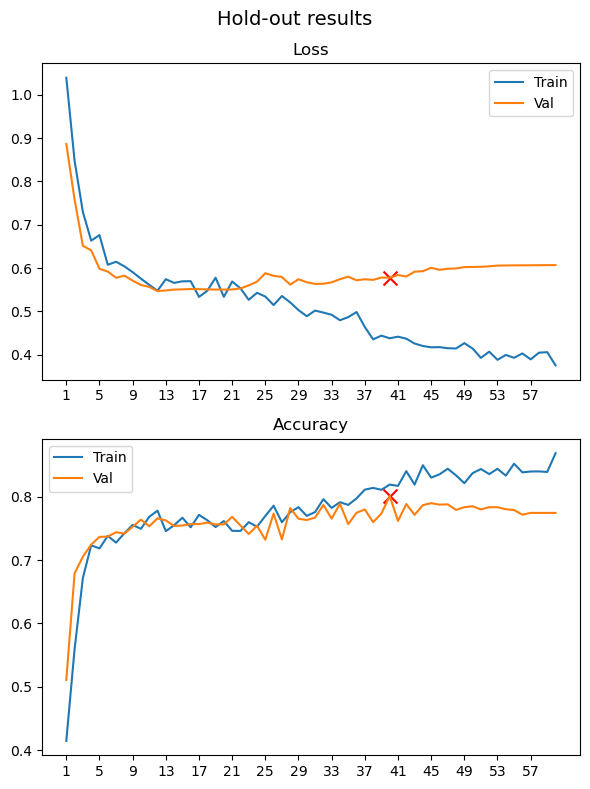

In [387]:
fig, axs = plt.subplots(2, figsize=(6, 4 * 2))

fig.suptitle("Hold-out results", fontsize=14)
util_plot.plot_model_results(axs[0], EPOCHS, losses, f"Loss")
axs[0].scatter(max_i + 1, losses["val"][max_i], marker="x", color="red", s=100, label=f"Min loss {losses['val'][max_i]:.3f} at epoch {max_i+1}")
util_plot.plot_model_results(axs[1], EPOCHS, accuracies, f"Accuracy")
axs[1].scatter(max_i + 1, max_acc, marker="x", color="red", s=100, label=f"Max accuracy {max_acc:.3f} at epoch {max_i+1}")

fig.tight_layout()

#### K-FOLD

In [205]:
EPOCHS = 60
n_losses, n_accuracies = train_test.kfold_train_model(
    X_train_val.values,
    y_train_val.values,
    N_SPLITS,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=0.001,
    print_every=EPOCHS,
    ce_weights=weights,
    reduce_lr=True,
    max_metric=0.78,
    name_model=path_save_model,
)

for i, acc in enumerate(n_accuracies):
    max_i, max_acc = np.argmax(acc["val"]), np.max(acc["val"])
    print(f"Fold {i+1}: Max accuracy {max_acc:.3f} at epoch {max_i}")


Epoch 060: | Loss: 0.61136 | Acc: 0.721 | Val loss: 0.65124 | Acc: 0.690
kfold on group 1 accuracy:  0.6902

Epoch 060: | Loss: 0.62171 | Acc: 0.712 | Val loss: 0.61687 | Acc: 0.712
kfold on group 2 accuracy:  0.7124

Epoch 060: | Loss: 0.61835 | Acc: 0.709 | Val loss: 0.69307 | Acc: 0.695
kfold on group 3 accuracy:  0.6952

Epoch 060: | Loss: 0.61441 | Acc: 0.721 | Val loss: 0.64963 | Acc: 0.713
kfold on group 4 accuracy:  0.7128

Epoch 060: | Loss: 0.61265 | Acc: 0.728 | Val loss: 0.64355 | Acc: 0.709
kfold on group 5 accuracy:  0.7087

Fold 1: Max accuracy 0.701 at epoch 47
Fold 2: Max accuracy 0.757 at epoch 41
Fold 3: Max accuracy 0.695 at epoch 58
Fold 4: Max accuracy 0.713 at epoch 55
Fold 5: Max accuracy 0.731 at epoch 52


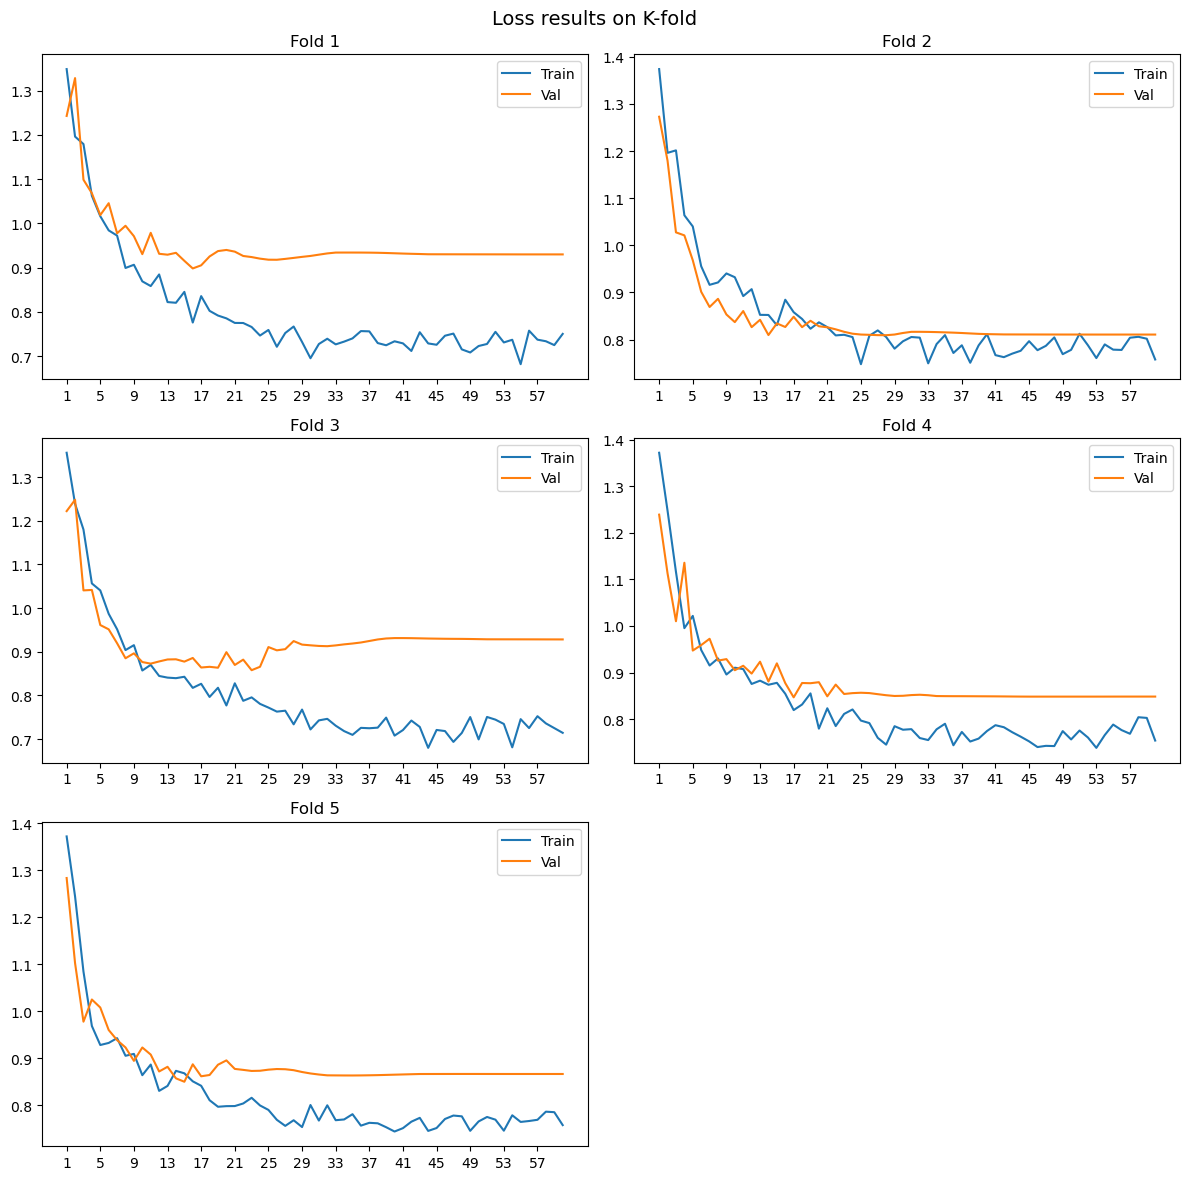

In [29]:
n_cols = 2
n_rows = math.ceil(N_SPLITS/2)
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 4 * n_rows))
faxs = axs.ravel()

fig.suptitle("Loss results on K-fold", fontsize=14)
for i, losses in enumerate(n_losses):
    util_plot.plot_model_results(faxs[i], EPOCHS, losses, f"Fold {i+1}")

for i in range(1, faxs.size - N_SPLITS + 1):
    faxs[-i].set_visible(False)

fig.tight_layout()

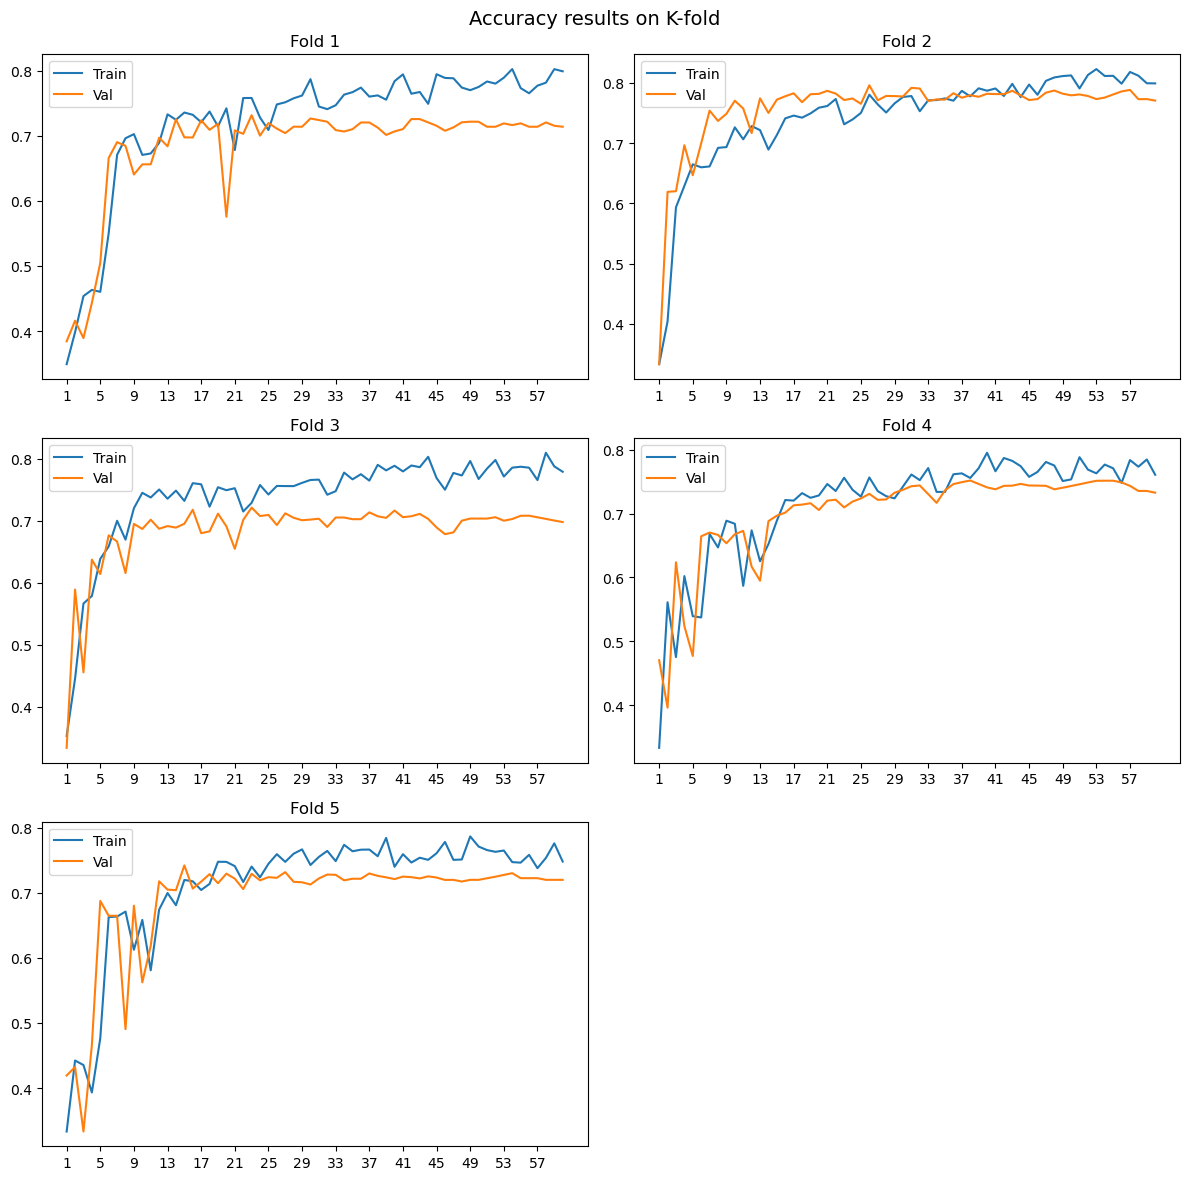

In [63]:
n_cols = 2
n_rows = math.ceil(N_SPLITS/2)
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 4 * n_rows))
faxs = axs.ravel()

fig.suptitle("Accuracy results on K-fold", fontsize=14)
for i, accuracies in enumerate(n_accuracies):
    util_plot.plot_model_results(faxs[i], EPOCHS, accuracies, f"Fold {i+1}")

for i in range(1, faxs.size - N_SPLITS + 1):
    faxs[-i].set_visible(False)

plt.tight_layout()

#### Random search

In [371]:
# Random values
lr_int = [0.005]
# lr_int = np.linspace(0.001, 0.01, num=10)
batch_int = [512]
# batch_int = [512, 1024, 2048]
dropout = [0, 0.1, 0.2, 0.3]
hidden_dim = [64, 128, 256]
num_layers = [3, 4, 5]
cosine_t0 = np.arange(5, 21, step=5)
cosine_tmult = np.arange(1, 4, step=1)

# Fixed values
epochs = 60
num_features = X_train_val.shape[1]
num_class = len(np.unique(y_train_val))
weights = util_models.compute_inverse_class_frequency(y_train_val.values, device)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_data = (X_train.values, y_train.values)
val_data = (X_val.values, y_val.values)

for i in range(20):
    lr_value = np.random.choice(lr_int)
    batch_value = int(np.random.choice(batch_int))
    dropout_value = np.random.choice(dropout)
    hidden_value = np.random.choice(hidden_dim)
    num_layers_value = np.random.choice(num_layers)
    cosine_t0_value = int(np.random.choice(cosine_t0))
    cosine_tmult_value = int(np.random.choice(cosine_tmult))

    hidden_layers = [hidden_value] * num_layers_value

    print(f"\n\nIteration {i+1}")
    print(f"Learning rate: {lr_value}")
    print(f"Batch size: {batch_value}")
    print(f"Dropout: {dropout_value}")
    print(f"Hidden layers: {hidden_layers}")
    print(f"Cosine t0: {cosine_t0_value}")
    print(f"Cosine tmult: {cosine_tmult_value}")

    nn_model = util_models.NNClassification(hidden_layers, num_features, num_class=num_class, dropout_rate=dropout_value).to(device)

    train_test = util_models.TrainTestNetwork(nn_model, util_models.multi_acc, device, SEED)


    losses, accuracies = train_test.train_model(
        train_data,
        val_data,
        epochs,
        batch_value,
        lr_value,
        print_every=epochs,
        reset_weights=True,
        ce_weights=weights,
        reduce_lr=False,
        cosine_annealing=True,
        cosine_t0=cosine_t0_value,
        cosine_tmult=cosine_tmult_value,
        max_metric=0.75,

    )

    max_i, max_acc = np.argmax(accuracies["val"]), np.max(accuracies["val"])
    print(f"Max accuracy {max_acc:.3f} at epoch {max_i+1}")



Iteration 1
Learning rate: 0.005
Batch size: 512
Dropout: 0.2
Hidden layers: [64, 64, 64, 64]
Cosine t0: 5
Cosine tmult: 1
Max accuracy so far: 0.753 at epoch 12
Max accuracy so far: 0.759 at epoch 13
Max accuracy so far: 0.763 at epoch 14
Max accuracy so far: 0.767 at epoch 15
Model saved with accuracy: 0.770 at epoch 34
Model saved with accuracy: 0.771 at epoch 58
Model saved with accuracy: 0.779 at epoch 59
Epoch 060: | Loss: 0.48112 | Acc: 0.780 | Val loss: 0.61300 | Acc: 0.763
Max accuracy 0.779 at epoch 59


Iteration 2
Learning rate: 0.005
Batch size: 512
Dropout: 0.1
Hidden layers: [128, 128, 128, 128]
Cosine t0: 5
Cosine tmult: 3
Max accuracy so far: 0.756 at epoch 11
Max accuracy so far: 0.759 at epoch 13
Max accuracy so far: 0.764 at epoch 14
Model saved with accuracy: 0.765 at epoch 22
Model saved with accuracy: 0.765 at epoch 23
Model saved with accuracy: 0.782 at epoch 25
Epoch 060: | Loss: 0.26929 | Acc: 0.912 | Val loss: 0.81711 | Acc: 0.736
Max accuracy 0.782 at epoc

### Test the model

#### Evaluate performance on test set

              precision    recall  f1-score   support

         low       0.84      0.84      0.84       187
      medium       0.70      0.70      0.70       145
        high       0.68      0.67      0.67        51

    accuracy                           0.77       383
   macro avg       0.74      0.74      0.74       383
weighted avg       0.76      0.77      0.76       383



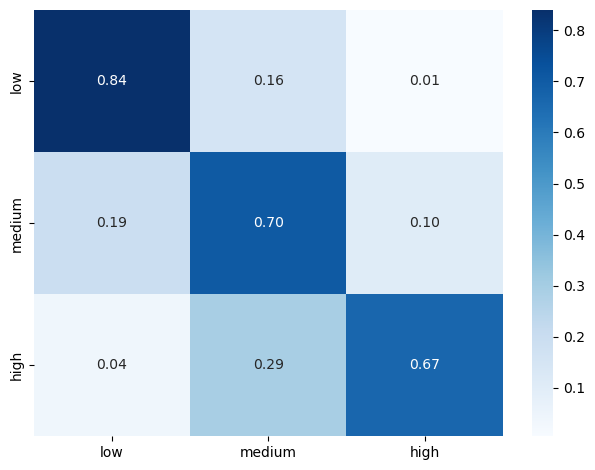

In [388]:
y_pred = train_test.test_model(X_test.values, 64)

count_labels, name_labels = [0,1, 2], ["low", "medium", "high"]
print(classification_report(y_test, y_pred, labels=count_labels, target_names=name_labels))

cm = confusion_matrix(y_test, y_pred, labels=count_labels, normalize="true")
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=name_labels,
            yticklabels=name_labels)
plt.tight_layout()

In [389]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.7365623783473682

In [390]:
def evaluate_predictions(y_test, y_pred):
    accuracy = sum([yp == yt for yp, yt in zip(y_pred, y_test)]) * 100 / len(y_test)
    return accuracy


accuracy = evaluate_predictions(y_test, y_pred)
print(f"Accuracy on test: {accuracy:.3f}")

Accuracy on test: 76.501


In [391]:
df_raw = pd.read_csv("data/processed/gsm_test.csv", index_col=0)

y_df = pd.DataFrame({"true": y_test, "pred": y_pred}, dtype=int, index=X_test.index)

In [331]:
gt_label = 1
p_label = 2

y_single = y_df[y_df.true == gt_label]
print(f"Number of rows: {len(y_single)}")

y_wrong = y_single[(y_single.pred == p_label)]
print(f"Number of rows: {len(y_wrong)}")

print(f"Ratio: {len(y_wrong)/len(y_single) * 100:.2f}%")

df_raw.loc[y_wrong.index].misc_price.describe()

Number of rows: 145
Number of rows: 23
Ratio: 15.86%


count     23.000000
mean     348.235948
std       47.251075
min      250.000000
25%      305.000000
50%      360.000000
75%      395.000000
max      410.000000
Name: misc_price, dtype: float64

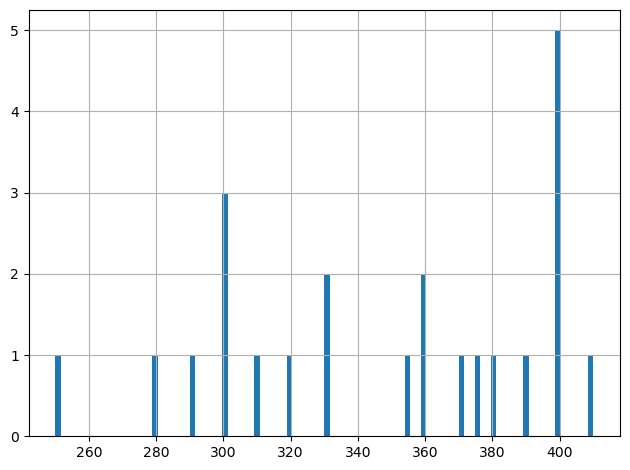

In [332]:
df_raw.loc[y_wrong.index].misc_price.hist(bins=100)
plt.tight_layout()

In [333]:
tmp_df = df_raw.loc[y_wrong.index]
# tmp_df[tmp_df.misc_price < 220].launch_announced.value_counts()
tmp_df.launch_announced.value_counts()

2018.0    6
2019.0    5
2017.0    4
2016.0    3
2020.0    3
2015.0    1
2014.0    1
Name: launch_announced, dtype: int64

#### Evaluate performance on training set

              precision    recall  f1-score   support

         low       0.83      0.85      0.84       716
      medium       0.72      0.71      0.72       593
 medium-high       0.77      0.71      0.74       213

    accuracy                           0.78      1522
   macro avg       0.77      0.76      0.76      1522
weighted avg       0.78      0.78      0.78      1522



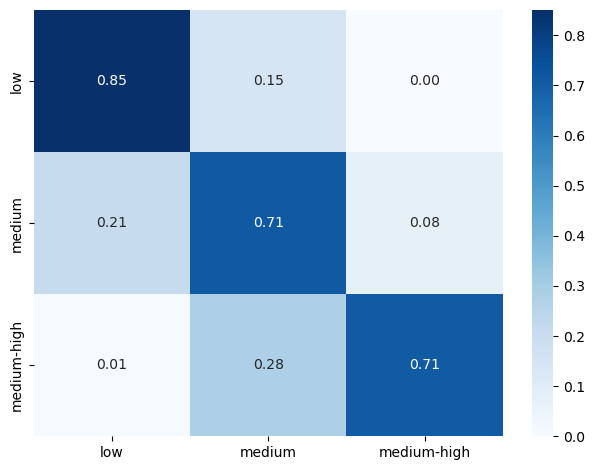

In [425]:
y_pred = train_test.test_model(X_train_val.values, 2048)

count_labels, name_labels = [0,1, 2], ["low", "medium", "medium-high"]
print(classification_report(y_train_val, y_pred, labels=count_labels, target_names=name_labels))

cm = confusion_matrix(y_train_val, y_pred, labels=count_labels, normalize="true")
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=name_labels,
            yticklabels=name_labels)
plt.tight_layout()

In [402]:
df_raw = pd.read_csv("data/processed/gsm_train.csv", index_col=0)
df_raw.head(n=3)

y_df = pd.DataFrame({"true": y_train_val, "pred": y_pred}, dtype=int, index=X_train_val.index)

In [403]:
gt_label = 2
p_label = 1

y_single = y_df[y_df.true == gt_label]
print(f"Number of rows: {len(y_single)}")

y_wrong = y_single[(y_single.pred == p_label)]
print(f"Number of rows: {len(y_wrong)}")

print(f"Ratio: {len(y_wrong)/len(y_single) * 100:.2f}%")

Number of rows: 213
Number of rows: 52
Ratio: 24.41%


In [404]:
df_raw.loc[y_wrong.index].misc_price.describe()

count     52.000000
mean     466.581994
std       44.568688
min      420.000000
25%      437.500000
50%      450.000000
75%      499.250000
max      580.000000
Name: misc_price, dtype: float64

<Axes: >

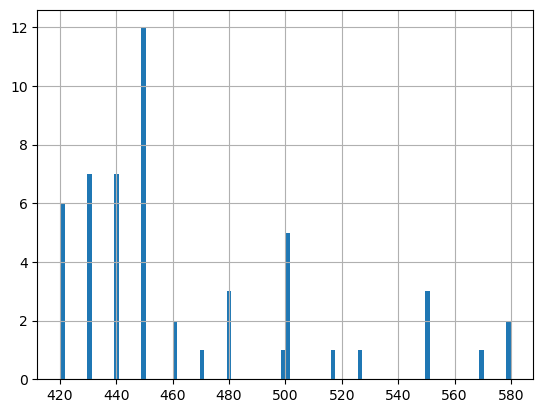

In [405]:
df_raw.loc[y_wrong.index].misc_price.hist(bins=100)

In [419]:
df_raw.loc[y_wrong.index].to_csv("tmp.csv")

## Counterfactual explanation

We have found two different libraries that allow to perform counterfactual explanation, the first one is OMLT and the second one is DICE.

In [98]:
from utils import util_counterfactual

Import the pipeline from the pickle to compute the inverse transformation of the features.

In [100]:
cols_pipeline = pickle.load(open("config/1_pipeline.pkl", "rb"))

### Generic pipeline

Using the following function you're allowed to generate a counterfactual simply passing the model, the counterfactual class (Omlt or Dice), the parameters to run the counterfactual generation and the sample for which to create a counterfactual.

In [101]:
from utils.util_models import evaluate_sample, get_correct_wrong_predictions
from utils.util_counterfactual import generate_counterfactual_from_sample

First of all we compute the indexes of the correctly predicted samples and the ones of the wrongly predicted samples such that we can perform two different analyses.

In [102]:
corr_ind, wrong_ind = get_correct_wrong_predictions(nn_model, X_test, y_test)
print(f"The correctly predicted samples are {len(corr_ind)}/{len(corr_ind)+len(wrong_ind)}.")

The correctly predicted samples are 273/383.


In [103]:
idx = corr_ind[0]

orig_sample = X_test.loc[[idx]].copy()
label_sample = y_test.loc[idx]

_ = evaluate_sample(nn_model, orig_sample, label_sample)

Logits: tensor([-0.8502,  2.0459, -0.8945])
Softmax: tensor([0.0499, 0.9025, 0.0477])
Predicted class 1 with probability: 0.902 and logit: 2.046
Marginal softmax: 0.103

The predicted class for the sample is equal to the groundtruth.


As you can see the sample with that index is predicted correctly by our model, therefore we can use it for the counterfactual without any problem.

At this point we need to initialize some variables to pass the correct parameters to the class and the correct parameters for the counterfactual generation. If we use the ***'multistart'*** solver we can also pass as parameter in 'solver_options' the restart strategy that we want to follow between:
- **"rand"**: random choice between variable bounds
- **"midpoint_guess_and_bound"**: midpoint between current value and farthest bound
- **"rand_guess_and_bound"**: random choice between current value and farthest bound
- **"rand_distributed"**: random choice among evenly distributed values
- **"midpoint"**: exact midpoint between the bounds. If using this option, multiple iterations are useless.

In [104]:
kwargs_cf_omlt = {
    "min_probability" : 0.6, 
    "obj_weights" : [1, 0.5, 0.8],
    "solver": "multistart", # 'mindtpy'
    "solver_options" : {"timelimit": 100, "strategy": "rand_guess_and_bound"},
    "verbose": True
}

kwargs_cf_dice = {
    "target" : "misc_price",
    "n_cf" : 1
}

continuous_feat = [
    "display_size", "battery", "memory_ram_gb", "memory_rom_gb", 
    "main_camera_resolution", "selfie_camera_resolution"
]

In [111]:
cfs = generate_counterfactual_from_sample(
        nn_model, "omlt", X_train_val, y_train_val, orig_sample, label_sample, 
        cont_feat=continuous_feat, type_cf="lower", pipeline=cols_pipeline, 
        **kwargs_cf_omlt
)

# Example for Dice
# cfs = generate_counterfactual_from_sample(
#         nn_model, "dice", X_train, y_train, orig_sample, label_sample, 
#         type_cf="lower", backend="PYT", target_dice="misc_price", dice_method='genetic', 
#         pipeline=cols_pipeline, **kwargs_cf_dice
# )

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================


Starting the search for a counterfactual ...
The counterfactual has been generated!



In [112]:
cfs[0]

,Original sample,Counterfactual_0
misc_price_min,210.000,40.000
misc_price_max,420.000,210.000
display_size,6.300,6.300
battery,4050.000,4049.995
memory_ram_gb,4.000,4.000
memory_rom_gb,64.000,64.000
main_camera_resolution,26.000,17.000
selfie_camera_resolution,13.000,13.000
display_resolution,FHD,qHD
network_technology,4G,3G


In [38]:
from sklearn.preprocessing import StandardScaler
tmp_std: StandardScaler = cols_pipeline.transformers_[1][1].named_steps["standardscaler"]
for name, mean, std in zip(tmp_std.feature_names_in_, tmp_std.mean_, tmp_std.scale_):
    print(f"{name}: {mean:.2f} +/- {std:.2f}")

display_size: 5.57 +/- 0.68
battery: 3180.81 +/- 879.60
memory_ram_gb: 3.33 +/- 3.32
memory_rom_gb: 46.11 +/- 52.98
main_camera_resolution: 15.85 +/- 13.05
selfie_camera_resolution: 8.39 +/- 7.49


In [48]:
dummy = np.zeros((1, 6))
dummy[0, 0] = 5.57 + 0.68 * 2
dummy[0, 1] = 3180.81 + 2 * 879.60
dummy[0, 2] = 3.33 - 3.32*2
print(f"Dummy sample: {dummy}")
tmp_std.transform(dummy)

Dummy sample: [[ 6.93000e+00  4.94001e+03 -3.31000e+00  0.00000e+00  0.00000e+00
   0.00000e+00]]


c:\Users\andre\miniconda3\envs\master-aiii\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution
0,2.011263,2.000014,-1.998402,-0.870427,-1.21473,-1.119338


### OMLT

Working with OMLT as framework, we need to encode ourselves all the constraints and the variables in order to compute a counterfactual sample. We use different domains (integers and reals) and bounds for the features, computed considering the distribution of the data.

We read a paper in which 3 different counterfactual objective functions are used, in order to meet respectively the proximity, sparsity and ... conditions.
Therefore we decided to implement this objectives doing some changes, for example we use a slightly different Gower distance and also the marginal softmax.

A marginal softmax computation is performed to compute the probability of the target class with log-linear complexity. However, instead of giving a probability distribution over the target class, it is more similar to a loss, which is minimized.

The minimum value of the marginal softmax for misclassified samples is approximately 0.70, thus a threshold of 0.70 or lower is used to find the counterfactuals.

Number of samples 1404
Minimum value of misclassified samples: 0.696


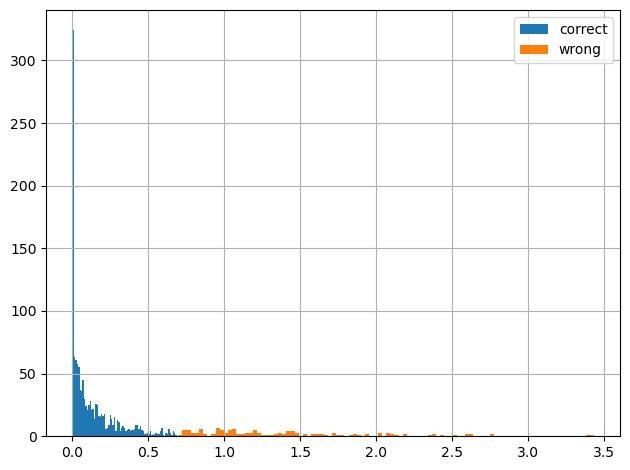

In [24]:
def difference_log_softmax(model, X, y, device):
    print(f"Number of samples {X.shape[0]}")
    model.eval()
    with torch.no_grad():
        correct_diff = []
        wrong_diff = []
        for i in range(X.shape[0]):
            X_i = torch.tensor(X[i], dtype=torch.float).view(1, -1).to(device)
            y_i = round(y[i])

            output = model(X_i)
            y_prob = torch.softmax(output, dim=1)
            y_pred = torch.argmax(y_prob, dim=1).item()

            marginal_softmax = torch.log(torch.sum(torch.exp(output))) - output.squeeze()[y_i].item()

            if y_pred == y_i:
                correct_diff.append(marginal_softmax)
            else:
                wrong_diff.append(marginal_softmax)


    return np.array(correct_diff), np.array(wrong_diff)

# compute marginal softmax
correct_diff, wrong_diff = difference_log_softmax(nn_model, X_train.values, y_train.values, device)
print(f"Minimum value of misclassified samples: {np.min(wrong_diff):.3f}")

# plot histogram
pd.Series(correct_diff).hist(bins=100, label="correct")
pd.Series(wrong_diff).hist(bins=100, label="wrong")
plt.legend()
plt.tight_layout()

TODO: add explanation about other parts of the objective functions?

We can test the OMLT model on a sample that we know is predicted correctly from our model. 

In [60]:
idx = 17
sample_idx = X_test.values[idx]
label_idx = y_test.values[idx]

_ = evaluate_sample(nn_model, sample_idx, label_idx, verbose=True)

Logits: tensor([ 4.9388,  1.5019, -7.9698])
Softmax: tensor([9.6884e-01, 3.1160e-02, 2.3994e-06])
Predicted class 0 with probability: 0.969 and logit: 4.939
Marginal softmax: 0.032

The predicted class for the sample is equal to the groundtruth.


When we initialize the OMLT class we need to specify which are the continuous features, such that it can set the correct domains and bounds for the Pyomo variables.

In [61]:
continuous_feat = [
    "display_size", "battery", "memory_ram_gb", "memory_rom_gb", 
    "main_camera_resolution", "selfie_camera_resolution"
]

omlt_count = util_counterfactual.OmltCounterfactual(
    X_train, y_train, nn_model, continuous_feat=continuous_feat
)

We can pass different parameters to generate a counterfactual, such as the minimum probability required for the counterfactual, the weights for the objective functions, the weights for the features, because some features are more expensive to be changed than the others. As last thing, we can tell the model not to change some features of the original sample.

In [65]:
cf_class = util_counterfactual.get_counterfactual_class(label_idx, 3, lower=True)

kwargs_cf_omlt = {
    "min_probability" : 0.6, 
    "obj_weights" : [1, 0.5, 0.8],
    "solver": "multistart", # 'mindtpy'
    "solver_options" : {"timelimit": 100, "strategy": "rand_guess_and_bound"},
    "verbose": False
}

In [63]:
complete_sample = np.append(sample_idx, label_idx)

The search may require some time (~ 60s) because the algorithm for the search is not optimized. We have to pass to the Omlt model the sample with the 'misc_price' as last value. 

In [30]:
cf = omlt_count.generate_counterfactuals(
    complete_sample, cf_class, **kwargs_cf_omlt
)

Starting MindtPy version 0.1.0 using OA algorithm
iteration_limit: 50
stalling_limit: 15
time_limit: 120
strategy: OA
add_regularization: None
call_after_main_solve: <pyomo.contrib.gdpopt.util._DoNothing object at 0x000002499F6E5040>
call_after_subproblem_solve: <pyomo.contrib.gdpopt.util._DoNothing object at 0x000002499F6E5070>
call_after_subproblem_feasible: <pyomo.contrib.gdpopt.util._DoNothing object at 0x000002499F6E50A0>
tee: true
logger: <Logger pyomo.contrib.mindtpy (INFO)>
logging_level: 20
integer_to_binary: false
add_no_good_cuts: false
use_tabu_list: false
single_tree: false
solution_pool: false
num_solution_iteration: 5
cycling_check: true
feasibility_norm: L_infinity
differentiate_mode: reverse_symbolic
use_mcpp: false
calculate_dual_at_solution: false
use_fbbt: false
use_dual_bound: true
partition_obj_nonlinear_terms: true
quadratic_strategy: 0
move_objective: false
add_cuts_at_incumbent: false
heuristic_nonconvex: false
init_strategy: rNLP
level_coef: 0.5
solution_limit

ERROR: Unable to clone Pyomo component attribute. Component
    'nn.layer[2515306537840].linear_activation_index' contains an uncopyable
    field '_init_dimen' (<class
    'pyomo.core.base.initializer.ConstantInitializer'>).  Setting field to
    `None` on new object
ERROR: Unable to clone Pyomo component attribute. Component
    'nn.layer[2515306537840].linear_activation_index' contains an uncopyable
    field '_init_values' (<class
    'pyomo.core.base.set.TuplizeValuesInitializer'>).  Setting field to `None`
    on new object


         -       Relaxed NLP          0.262287            inf       0.262287      nan%      1.98
         1              MILP           5.60931            inf        5.60931      nan%      7.88
*        1         Fixed NLP           5.61002        5.61002        5.60931     0.01%      9.10
MindtPy exiting on bound convergence. Relative gap : 0.00012672537960432595 <= relative tolerance: 0.001 

 Primal integral          :    0.0000 
 Dual integral            :   10.5773 
 Primal-dual gap integral :   10.5773 


At the end we need to transform the values of the features in order to check the real value of the generated device.

In [33]:
pairs = omlt_count.destandardize_cfs_orig(cols_pipeline)

In [34]:
comp_df = omlt_count.compare_sample_cf(pairs)
comp_df[0]

,Original sample,Counterfactual_0
price_min,375.633,184.060
price_max,1500.000,375.633
display_size,7.200,6.246
battery,5000.000,4050.627
memory_ram_gb,6.000,6.000
memory_rom_gb,128.000,19.595
main_camera_resolution,40.000,27.968
selfie_camera_resolution,24.000,15.879
has_oled_display,1.000,1.000
has_memory_card_slot,0.000,0.000


#### PCA of features

TODO: find a way to check the computed counterfactuals visually.

<Axes: xlabel='PC1', ylabel='PC2'>

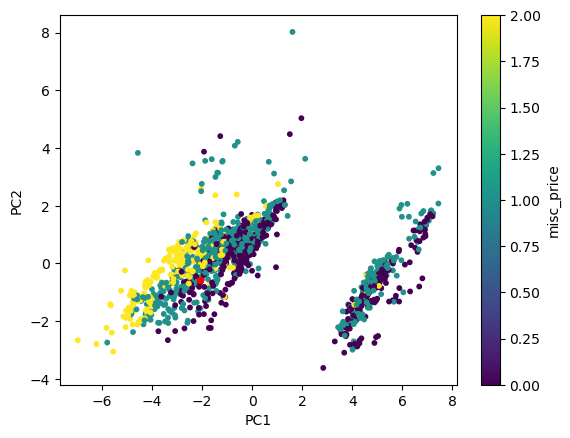

In [115]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

train_pca = pd.DataFrame(X_train_pca, columns=["PC1", "PC2"], index=X_train.index)
train_pca["misc_price"] = y_train

fig, axs = plt.subplots()
train_pca.plot.scatter(x="PC1", y="PC2", c="misc_price", colormap="viridis", ax=axs, s=10)

X_new_sample_pca = pca.transform(new_sample)
new_sample_pca = pd.DataFrame(X_new_sample_pca, columns=["PC1", "PC2"], index=new_sample.index)
new_sample_pca.plot.scatter(x="PC1", y="PC2", c="red", s=20, ax=axs)

In [133]:
def compute_distance(x, y):
    return np.linalg.norm(x - y, ord=2, axis=1)

same_label_train = train_pca[train_pca.misc_price == cf_class]
counterfactual_distance = same_label_train.apply(lambda x: compute_distance(x[["PC1", "PC2"]], new_sample_pca), axis=1)
counterfactual_distance = counterfactual_distance.sort_values()

min_index = counterfactual_distance.index[0]
closer_sample = X.loc[min_index]

# closer_sample
print(f"Distance to the closest sample: {counterfactual_distance.iloc[0]}\n")
print(f"Price of the closest sample: {y_train.loc[min_index]}\n")
print(f"Features of the closest sample:\n{closer_sample}")

Distance to the closest sample: [0.05524922]

Price of the closest sample: 1.0

Features of the closest sample:
display_size                0.824933
battery                     0.817902
memory_ram_gb               0.616541
memory_rom_gb               0.716839
main_camera_resolution     -0.443149
selfie_camera_resolution    0.360172
has_oled_display            0.000000
has_memory_card_slot        1.000000
has_stereo_speakers         0.000000
has_3.5mm_jack              1.000000
has_wlan_5ghz               1.000000
has_nfc                     0.000000
has_wireless_charging       0.000000
is_waterproof               0.000000
network_technology          1.000000
num_main_camera             2.000000
num_selfie_camera           0.000000
display_resolution          2.000000
Name: 1559, dtype: float64


In [134]:
df_closer_sample = pd.DataFrame(closer_sample.to_numpy().reshape(1, -1), columns=X.columns, index=["Closer sample"])
features_df = pd.concat([new_sample, df_closer_sample], axis=0)

label_df = pd.Series([cf_class, y_train.loc[min_index]], name="misc_price", index=features_df.index).to_frame()
comp_df = pd.concat([features_df, label_df], axis=1)

inverse_pipeline(cols_pipeline, comp_df)


,price_min,price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof,network_technology,num_main_camera,num_selfie_camera,display_resolution
Counterfactual,184.060285,375.632818,6.39,4000.0,4.0,32.0,16.0,16.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,4G,2.0,1.0,HD
Closer sample,184.060285,375.632818,6.26,4000.0,4.0,64.0,12.0,8.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,4G,3.0,1.0,FHD


### Dice

We concatenate the X with the labels because Dice expects a unique dataframe and then you specify which column is the target one.

In [35]:
df_dice = pd.concat([X_train, y_train], axis=1)
df_dice.head()

,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof,network_technology,num_main_camera,num_selfie_camera,display_resolution,misc_price
199,-0.840250,-0.899056,-0.701774,-0.794924,-0.601733,-1.079298,0,1,0,1,0,0,0,0,0.0,0.0,0.0,0.0,1.0
1377,1.375952,0.931330,0.200752,1.545659,-0.218609,1.016146,0,1,0,1,1,0,0,0,1.0,1.0,1.0,2.0,1.0
798,-0.840250,-1.046851,-0.400932,-0.568416,-0.218609,-0.452000,1,1,0,1,0,0,0,0,1.0,0.0,0.0,1.0,1.0
1235,-0.840250,-0.148712,-0.100090,-0.266406,0.011265,-0.452000,0,1,0,1,0,0,0,0,1.0,0.0,0.0,1.0,1.0
1589,1.154332,2.068216,0.200752,1.545659,-0.218609,1.550017,0,1,0,1,0,0,0,0,1.0,2.0,0.0,1.0,1.0


We initialize an instance of the class that we created for dealing with Dice and generating counterfactuals. In this case we need to pass as continuous features all the numerical ones (all the features), otherwise Dice will convert the values to strings.

In [36]:
cont_features = list(df_dice.columns) 
cont_features.remove("misc_price")

dice_cf = util_counterfactual.DiceCounterfactual(nn_model, 'PYT', df_dice, cont_features, target="misc_price")

In the first example we only choose one sample, that originally has label 2 (medium-high price) and we want to produce a counterfactual that has label 1 to check which features we can change to decrease the price.

In [37]:
idx = 17
orig_sample = X_test.iloc[[idx]].copy()
orig_sample_lab = y_test.iloc[[idx]].copy()

count_class = util_counterfactual.get_counterfactual_class(orig_sample_lab.values[0], 3, lower=True)

orig_sample.loc[:,'misc_price'] = orig_sample_lab

We may use the genetic method to generate the counterfactuals because is the fastest one available in Dice.

In [38]:
dice_cf.create_explanation_instance(method="genetic")

cfs = dice_cf.generate_counterfactuals(orig_sample, new_class=count_class, target="misc_price", n_cf=1)

100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


We standardize the original samples and the counterfactuals to get real values for the devices.

In [39]:
pairs = dice_cf.destandardize_cfs_orig(pipeline=cols_pipeline)

After that we got the sample - counterfactuals pairs we can pass them to a function in order to compare the differences in the features that allow to classify the sample as the desired class.

In [40]:
compare_dfs = dice_cf.compare_sample_cf(pairs)

At the end we can print the comparison for all the samples for which we generated the counterfactuals simply retrieving the dataframe from the list.

In [41]:
compare_dfs[0]

,Original sample,Counterfactual_0
price_min,375.633,184.060
price_max,1500.000,375.633
display_size,7.200,6.400
battery,5000.000,4035.000
memory_ram_gb,6.000,4.000
memory_rom_gb,128.000,128.000
main_camera_resolution,40.000,48.000
selfie_camera_resolution,24.000,32.000
has_oled_display,1,1.000
has_memory_card_slot,0,0.000
